In [2]:
# Setup
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial
import matplotlib.pyplot as plt

# Read the dummy data
data = pd.read_csv("../data/data_censored.csv")
print("Data shape:", data.shape)
data.head()


Data shape: (725, 12)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [3]:
# Data Preparation
print(data.info())
print(data.describe())

data_pp = data.copy()
data_itt = data.copy()

estimand_pp = "PP"
estimand_itt = "ITT"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB
None
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.4

In [5]:
# Weight Models and Censoring
data_itt['not_censored'] = 1 - data_itt['censored']

model_numerator_itt = glm("not_censored ~ x2", data=data_itt, family=Binomial()).fit()
print("ITT Censor Numerator Model Summary")
print(model_numerator_itt.summary())

model_denominator_itt = glm("not_censored ~ x2 + x1", data=data_itt, family=Binomial()).fit()
print("ITT Censor Denominator Model Summary")
print(model_denominator_itt.summary())

data_itt['p_num'] = model_numerator_itt.predict(data_itt)
data_itt['p_den'] = model_denominator_itt.predict(data_itt)
data_itt['censor_ipw'] = data_itt['p_num'] / data_itt['p_den']


ITT Censor Numerator Model Summary
                 Generalized Linear Model Regression Results                  
Dep. Variable:           not_censored   No. Observations:                  725
Model:                            GLM   Df Residuals:                      723
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.70
Date:                Sun, 09 Mar 2025   Deviance:                       393.40
Time:                        18:07:23   Pearson chi2:                     722.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01481
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.

In [6]:
# Calculate Weights
print(data_itt['censor_ipw'].describe())

cutoff_99 = data_itt['censor_ipw'].quantile(0.99)
data_itt['censor_ipw'] = np.where(data_itt['censor_ipw'] > cutoff_99, cutoff_99, data_itt['censor_ipw'])


count    725.000000
mean       1.000825
std        0.028269
min        0.911078
25%        0.974673
50%        1.011274
75%        1.021365
max        1.129321
Name: censor_ipw, dtype: float64


In [7]:
# Specify Outcome Model
data_itt['followup_time'] = data_itt['period']

formula_itt = "outcome ~ treatment + x2 + followup_time + I(followup_time**2)"
weights_itt = data_itt['censor_ipw']

model_outcome_itt = glm(formula_itt, data=data_itt, family=Binomial(), freq_weights=weights_itt).fit()
print("ITT Outcome Model Summary")
print(model_outcome_itt.summary())


ITT Outcome Model Summary
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                   720.43
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.640
Date:                Sun, 09 Mar 2025   Deviance:                       109.28
Time:                        18:07:34   Pearson chi2:                     733.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.006023
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Inte

In [8]:
# Expand Trials
expanded_data_itt = []
for pid, group in data_itt.groupby('id'):
    max_period = group['period'].max()
    for t in range(max_period + 1):
        row = group[group['period'] == t]
        if not row.empty:
            expanded_data_itt.append(row.iloc[0].to_dict())

expanded_data_itt = pd.DataFrame(expanded_data_itt)
print("Expanded data shape:", expanded_data_itt.shape)


Expanded data shape: (725, 17)


In [9]:
# Sampling from Expanded Data
np.random.seed(1234)
mask = (expanded_data_itt['outcome'] == 0) & (np.random.rand(len(expanded_data_itt)) > 0.5)
sampled_data_itt = expanded_data_itt[~mask].copy()
print("Sampled data shape:", sampled_data_itt.shape)


Sampled data shape: (355, 17)


In [10]:
msm_formula = "outcome ~ treatment + x2 + followup_time + I(followup_time**2)"
msm_weights = sampled_data_itt['censor_ipw'].fillna(1.0)

model_msm_itt = glm(msm_formula,
data=sampled_data_itt,
family=Binomial(),
freq_weights=msm_weights
).fit()

print("Final MSM Model Summary (ITT):")
print(model_msm_itt.summary())

Final MSM Model Summary (ITT):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  355
Model:                            GLM   Df Residuals:                   350.49
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46.934
Date:                Sun, 09 Mar 2025   Deviance:                       93.868
Time:                        18:10:09   Pearson chi2:                     369.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01115
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [12]:
predict_times = np.arange(0, 11, 1)
preds_t0= []
preds_t1= []

for ft in predict_times:
# Force 'treatment=0' vs 'treatment=1'
    df0 = pd.DataFrame({
        'treatment': [0],
        'x2': [0.0], # or some typical value
        'followup_time': [ft]
    })
    df1 = df0.copy()
    df1['treatment'] = 1

    p0 = model_msm_itt.predict(df0)
    p1 = model_msm_itt.predict(df1)

    # logistic -> probability of outcome. 
    # If the “outcome” is an event, you’d interpret it. 
    # For survival, you might do 1 - predicted_risk if outcome=1 means event.

    preds_t0.append((ft, p0[0]))
    preds_t1.append((ft, p1[0]))

preds_t0 = pd.DataFrame(preds_t0, columns=['followup_time', 'p_event_t0'])
preds_t1 = pd.DataFrame(preds_t1, columns=['followup_time', 'p_event_t1'])

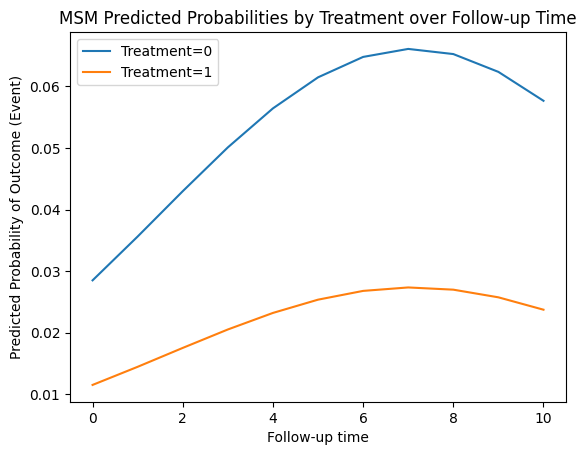

In [13]:
plt.plot(preds_t0['followup_time'], preds_t0['p_event_t0'], label='Treatment=0')
plt.plot(preds_t1['followup_time'], preds_t1['p_event_t1'], label='Treatment=1')
plt.xlabel("Follow-up time")
plt.ylabel("Predicted Probability of Outcome (Event)")
plt.title("MSM Predicted Probabilities by Treatment over Follow-up Time")
plt.legend()
plt.show()